In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [2]:
def dual_path_block(x, filters, alpha, kernel_size=(3, 3), stride=(1, 1), padding='same'):
    main_path_H, main_path_L = OctConv2D(filters, alpha, kernel_size=kernel_size, strides=stride, padding=padding)([x, x])
    main_path_H = BatchNormalization()(main_path_H)
    main_path_L = BatchNormalization()(main_path_L)
    main_path_H = Activation('relu')(main_path_H)
    main_path_L = Activation('relu')(main_path_L)

    parallel_path_H, parallel_path_L = OctConv2D(filters, alpha, kernel_size=(1, 1), strides=(1, 1), padding='same')([x, x])
    parallel_path_H = BatchNormalization()(parallel_path_H)
    parallel_path_L = BatchNormalization()(parallel_path_L)
    parallel_path_H = Activation('relu')(parallel_path_H)
    parallel_path_L = Activation('relu')(parallel_path_L)
    parallel_path_H, parallel_path_L = OctConv2D(filters, alpha, kernel_size=kernel_size, strides=stride, padding=padding)([parallel_path_H, parallel_path_L])
    parallel_path_H = BatchNormalization()(parallel_path_H)
    parallel_path_L = BatchNormalization()(parallel_path_L)
    parallel_path_H = Activation('relu')(parallel_path_H)
    parallel_path_L = Activation('relu')(parallel_path_L)

    concat_H = concatenate([main_path_H, parallel_path_H], axis=-1)
    concat_L = concatenate([main_path_L, parallel_path_L], axis=-1)
    return [concat_H, concat_L]

In [10]:
communication_options = tf.distribute.experimental.CommunicationOptions(
    implementation=tf.distribute.experimental.CommunicationImplementation.RING)
strategy = tf.distribute.MultiWorkerMirroredStrategy(communication_options=communication_options)
with strategy.scope():
    input_size = (224, 224, 3)

# Model architecture using MobileNetV2 for classification
input_layer = Input(shape=input_size)

# Feature extraction using MobileNetV2
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_size)
mobilenet_model.trainable = False

mobilenet_output = mobilenet_model(input_layer)

# Global Average Pooling
x_mobilenet = GlobalAveragePooling2D()(mobilenet_output)

# Fully connected layers for classification
x_mobilenet = Dense(128, activation='relu')(x_mobilenet)
x_mobilenet = Dense(64, activation='relu')(x_mobilenet)

predictions_mobilenet = Dense(1, activation='softmax')(x_mobilenet)

# Create the final model
model_mobilenet = tf.keras.models.Model(inputs=input_layer, outputs=predictions_mobilenet)



model_mobilenet = tf.keras.models.Model(inputs=input_layer, outputs=predictions_mobilenet)


# Compile the MobileNetV2 model
model_mobilenet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.RING


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data=ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
test_data=ImageDataGenerator(rescale=1./255)

In [12]:
from tensorflow.keras.callbacks import Callback
#x_train = train_data.flow_from_directory('C:\\Users\\bvcha\\Desktop\\Senior Design Project\\Datasets\\PaddyDoctor\\PaddyDoctorMedium', target_size=(64, 64), class_mode='categorical', batch_size=64)
#x_test = test_data.flow_from_directory('C:\\Users\\bvcha\\Desktop\\Senior Design Project\\Datasets\\validation_set', target_size=(64, 64), class_mode='categorical', batch_size=64, shuffle=False)
data_dir = 'C:\\Users\\bvcha\\Desktop\\Senior Design Project\\Datasets\\PaddyDoctor\\PaddyDoctorMedium'

print('Training Images:')
# creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=128)

#Testing Augmented Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=128)
# Define a custom callback to stop training when the validation accuracy reaches a certain threshold
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.99:
            self.model.stop_training = True

# Instantiate the custom callback
callback = CustomCallback()

# Train the model
history = model_mobilenet.fit_generator(
    train_ds,
    steps_per_epoch=len(train_ds),
    epochs=20,
    validation_data=validation_ds,
    validation_steps=len(validation_ds),
    callbacks=[callback]
)

Training Images:
Found 16225 files belonging to 13 classes.
Using 14603 files for training.
Validation Images:
Found 16225 files belonging to 13 classes.
Using 1622 files for validation.
Epoch 1/20


C:\Users\bvcha\AppData\Local\Temp\ipykernel_3580\1797443857.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_mobilenet.fit_generator(
c:\Users\bvcha\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


115/115 [==============================] - 167s 1s/step - loss: 0.0000e+00 - accuracy: 0.0318 - val_loss: 0.0000e+00 - val_accuracy: 0.0253
Epoch 2/20
115/115 [==============================] - 167s 1s/step - loss: 0.0000e+00 - accuracy: 0.0318 - val_loss: 0.0000e+00 - val_accuracy: 0.0253
Epoch 3/20
115/115 [==============================] - 166s 1s/step - loss: 0.0000e+00 - accuracy: 0.0318 - val_loss: 0.0000e+00 - val_accuracy: 0.0253
Epoch 4/20
115/115 [==============================] - 160s 1s/step - loss: 0.0000e+00 - accuracy: 0.0318 - val_loss: 0.0000e+00 - val_accuracy: 0.0253
Epoch 5/20
115/115 [==============================] - 148s 1s/step - loss: 0.0000e+00 - accuracy: 0.0318 - val_loss: 0.0000e+00 - val_accuracy: 0.0253
Epoch 6/20
115/115 [==============================] - 147s 1s/step - loss: 0.0000e+00 - accuracy: 0.0318 - val_loss: 0.0000e+00 - val_accuracy: 0.0253
Epoch 7/20
115/115 [==============================] - 154s 1s/step - loss: 0.0000e+00 - accuracy: 0.0318 

In [ ]:
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 20)                1300  

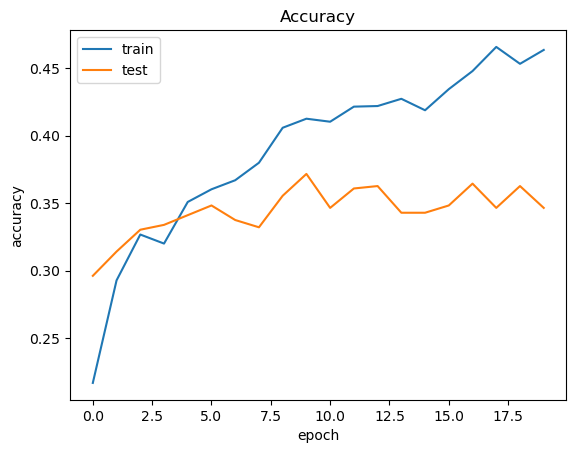

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

In [ ]:
model_mobilenet.evaluate(x_test)

9/9 [==============================] - 30s 3s/step - loss: 2.1349 - accuracy: 0.3465


[2.1349380016326904, 0.34649911522865295]